In [1]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import transformers
from transformers import BertTokenizer, BertForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from TextClassificationDataset import TCD

c:\Users\Cactus\miniconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Constants/Hyper-parameter
EPOCH = 4
NUMLABELS = 3
BATCHSIZE = 8

In [3]:
#initialize useful models and tools

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#num_labels represents number of possible type for classification
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUMLABELS)
train_data = TCD('RawData.JSON', training_set=True) #note: default is true
train_loader = DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#test train_loader
questions, labels = next(iter(train_loader))
print("Question: ", questions[0])
print("Label: ", labels[0].numpy())

Question:  Arrange an Irish reel for chamber ensemble.
Label:  2


In [5]:
#Preprocess a given batch of questions to its inputID and attMask
def preprocess(questions):
    encoded_batch = tokenizer.batch_encode_plus(
        questions,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']
    return input_ids, attention_masks

In [6]:
#Test preprocessing tokenized sentences
questions, labels = next(iter(train_loader))
print("Question: ", questions[0], '\n')
input_ids, att_masks = preprocess(questions)
print("Tokenized to #: ", input_ids[0])
print("Attention mask: ", att_masks[0])

Question:  Transcribe a tabla solo and analyze rhythmic patterns and improvisational techniques within the context of Indian classical music 

Tokenized to #:  tensor([  101,  9099, 26775, 20755,  1037, 21628,  2721,  3948,  1998, 17908,
        14797,  7060,  1998, 24584,  2389,  5461,  2306,  1996,  6123,  1997,
         2796,  4556,  2189,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [7]:
# Training the model
def train(model, train_loader, optimizer, criterion, device, num_epochs):
    model = model.to(device)
    loss_history = []
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            # Training loop
            for questions, labels in train_loader:
                input_ids, attention_masks = preprocess(questions)
                # Move inputs and labels to device
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                labels = torch.tensor(labels) #want the type to be torch tensor
                labels = labels.to(device)

                optimizer.zero_grad()

                # Compute loss using the logits, by applying cross entropy
                outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                outputs = outputs.logits
                loss = criterion(outputs, labels)

                # Backpropagate and update weight accordingly
                loss.backward()
                optimizer.step()

                # Update Progress Bar, showing current loss
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        loss_history.append(loss.item())

    return loss_history
    #Note: eval is ignored here

In [8]:
# Activate 'cuda' if there's GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training
loss_history = train(pretrained_model, train_loader, optimizer, criterion, device, num_epochs=EPOCH)

# Save the trained result
torch.save(pretrained_model.state_dict(), 'bert_fine_tuned.pt')

Epoch 1/4:   0%|          | 0/36 [00:00<?, ?it/s]C:\Users\Cactus\AppData\Local\Temp\ipykernel_32184\4292679310.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels) #want the type to be torch tensor
Epoch 4/4: 100%|██████████| 36/36 [00:27<00:00,  1.31it/s, loss=0.00919]


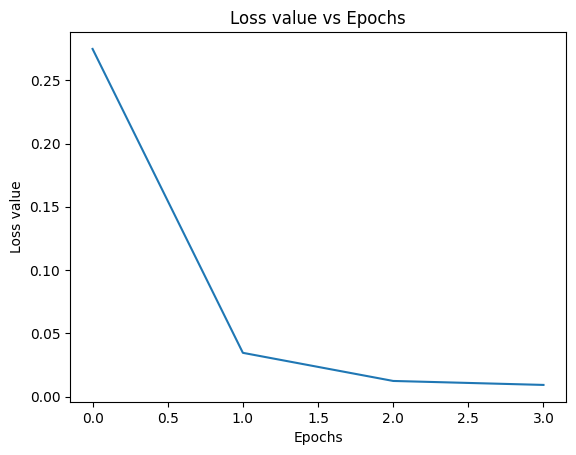

CUDA is not available. GPU support is not enabled.


In [9]:
#Show how the loss progresses
plt.plot(loss_history)
plt.title('Loss value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

if torch.cuda.is_available():
    print("CUDA is available. GPU support is enabled.")
else:
    print("CUDA is not available. GPU support is not enabled.")

In [10]:
# Use the model to classify a sentence of a user input

#This provide necessary logits for sequence classification, rather than plain BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUMLABELS)
model.load_state_dict(torch.load('bert_fine_tuned.pt'))
# Make sure that the model is no longer training
model.eval()

print("\nWhat assignment are you working on today? (Press 'q' or 'quit' to exit)")
while(True):
    # Getting user input for the assignment
    sentence = input("You: ")
    print(sentence)
    if sentence == "quit" or sentence == "q":
        break
    # Tokenize the Sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    # Forward pass through the model, don't need to calculate gradient

    with torch.no_grad():
        outputs = model(**inputs)
    # Get the predicted class probabilities
    predictions = torch.softmax(outputs.logits, dim=1)
    prob = torch.max(predictions)
    # Get the predicted class label (index with the highest probability)
    predicted_class = torch.argmax(predictions, dim=1).item()
    print(predictions)
    
    if(prob<0.88):
        print("Word it differently please, try to add keywords like 'essay', 'eigenvalue', 'graph' etc.")
        print("Try Again Please: ")
    else:
        #choose 5 random achievements from the corresponding item
        map = train_data.__getMap__(predicted_class)
        length = len(map)
        indices = np.random.choice(length, 5, replace=False)
        print('\n')
        for i, n in enumerate(indices):
            print(f"{i + 1}. {map[n]}")
        break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



What assignment are you working on today? (Press 'q' or 'quit' to exit)
Learn to find the sum of the factorials listed
tensor([[0.0033, 0.9885, 0.0082]])


1. Made significant strides in time management and prioritization, allowing for more efficient completion of assignment tasks.
2. Implemented advanced mathematical tools or software to streamline complex calculations and analyses.
3. Utilized feedback from instructors or peers to refine problem-solving techniques and improve solution quality.
4. Developed innovative problem-solving strategies that proved effective in solving a variety of assignment problems.
5. Developed a deeper appreciation for the interconnectedness of different mathematical concepts addressed in the assignment.
